## **Importing Libraries & Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
published_data = pd.read_csv("/content/drive/MyDrive/patent_published.csv")
granted_data = pd.read_csv("/content/drive/MyDrive/patent_granted.csv")

<ipython-input-3-2498985483>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  published_data = pd.read_csv("/content/drive/MyDrive/patent_published.csv")


In [15]:
print("Published:",len(published_data))
print("Granted:", len(granted_data))

Published: 395162
Granted: 290388


In [11]:
published_data.head()

,Unnamed: 0,PUBLICATION_NUMBER,IPO_LOCATION,APPLICATION_TYPE_DESC,APPLICATION_NUMBER,DATE_OF_FILING,TITLE_OF_INVENTION,FIELD_OF_INVENTION,NO_OF_PAGES,NO_OF_CLAIMS
PUBLICATION_DATE,,,,,,,,,,
2016-08-31,0,36/2016,Delhi,PCT NATIONAL PHASE APPLICATION,6439/DELNP/2011,24/08/2011,SYSTEM FOR NONINVASIVE DETERMINATION OF ALCOHO...,BIOTECHNOLOGY,88,32
2016-08-31,1,36/2016,Delhi,PCT NATIONAL PHASE APPLICATION,6442/DELNP/2011,24/08/2011,ELECTRODE PLATE FOR A BATTERY,ELECTRICAL,21,43
2016-08-31,2,36/2016,Delhi,PCT NATIONAL PHASE APPLICATION,6498/DELNP/2011,25/08/2011,"""SUBSTITUTED 1,1,3,3-TETRAOXIDOBENZO[D][1,3,2]...",CHEMISTRY,161,159
2016-08-31,3,36/2016,Delhi,CONVENTION APPLICATION,652/DEL/2009,31/03/2009,"""PARTITION-FREE MULTI-SOCKET MEMORY SYSTEM ARC...",ELECTRONICS,32,30
2016-08-31,4,36/2016,Delhi,CONVENTION APPLICATION,658/DEL/2015,11/03/2015,PROCESS FOR WELDING PIPE CONNECTINS FOR HIGH T...,MECHANICAL,16,10


In [12]:
granted_data.head()

,PUBLICATION_NUMBER,IPO_LOCATION,APPLICATION_TYPE_DESC,APPLICATION_NUMBER,DATE_OF_FILING,TITLE_OF_INVENTION,FIELD_OF_INVENTION,NO_OF_PAGES,NO_OF_CLAIMS
PUBLICATION_DATE,,,,,,,,,
2016-12-02,50/2016,Chennai,PCT NATIONAL PHASE APPLICATION,1010/CHENP/2008,29/02/2008,A TIME-BASED COEXISTENCE METHOD FOR WIRELESS C...,ELECTRONICS,25,22
2016-12-02,50/2016,Kolkata,CONVENTION APPLICATION,108/KOL/2009,20/01/2009,MULTI-SPEED TRANSAXLE FOR A FRONT WHEEL DRIVE ...,MECHANICAL,26,21
2016-12-02,50/2016,Chennai,CONVENTION APPLICATION,1471/CHE/2009,23/06/2009,INJECTION MOLD AND MOLDING METHOD FOR RESIN MO...,MECHANICAL,27,12
2016-12-02,50/2016,Delhi,PCT NATIONAL PHASE APPLICATION,1762/DELNP/2003,28/10/2003,"""PROCESS FOR THE PREPARATION OF AZOXYSTROBIN A...",CHEMISTRY,18,10
2016-12-02,50/2016,Kolkata,PCT NATIONAL PHASE APPLICATION,1777/KOLNP/2010,17/05/2010,PROCESS FOR PREPARING TUBULYSINS,CHEMISTRY,38,12


##  **Data Preprocessing**

- Converted `PUBLICATION_DATE` to datetime
- Set as index for weekly resampling
- Resampled to weekly frequency for published and granted counts
- Merged both datasets to allow comparison


In [4]:
#Convert date columns to datetime
published_data['PUBLICATION_DATE'] = pd.to_datetime(published_data['PUBLICATION_DATE'], dayfirst=True, errors='coerce')
granted_data['PUBLICATION_DATE'] = pd.to_datetime(granted_data['PUBLICATION_DATE'], dayfirst=True, errors='coerce')

In [5]:
#Set 'publication date' as index
published_data.set_index('PUBLICATION_DATE', inplace=True)
granted_data.set_index('PUBLICATION_DATE', inplace=True)

In [6]:
# Weekly count of published patents
published_weekly = published_data.resample('W').size().reset_index()
published_weekly.columns = ['Week_Start_Date', 'Published_Count']

# Weekly count of granted patents
granted_weekly = granted_data.resample('W').size().reset_index()
granted_weekly.columns = ['Week_Start_Date', 'Granted_Count']

In [7]:
# Merge on Week_Start_Date to align published and granted counts
weekly_data = pd.merge(published_weekly, granted_weekly, on='Week_Start_Date', how='outer').sort_values('Week_Start_Date')

# Fill any missing values (e.g., weeks where only published or granted existed)
weekly_data.fillna(0, inplace=True)

# Optional: Convert counts to integers
weekly_data[['Published_Count', 'Granted_Count']] = weekly_data[['Published_Count', 'Granted_Count']].astype(int)

In [8]:
weekly_data.head()

,Week_Start_Date,Published_Count,Granted_Count
0,2016-01-03,515,182
1,2016-01-10,212,130
2,2016-01-17,491,98
3,2016-01-24,451,73
4,2016-01-31,290,160


## **Weekly Patent Trends**

The plot below shows the number of patents published and granted every week.  

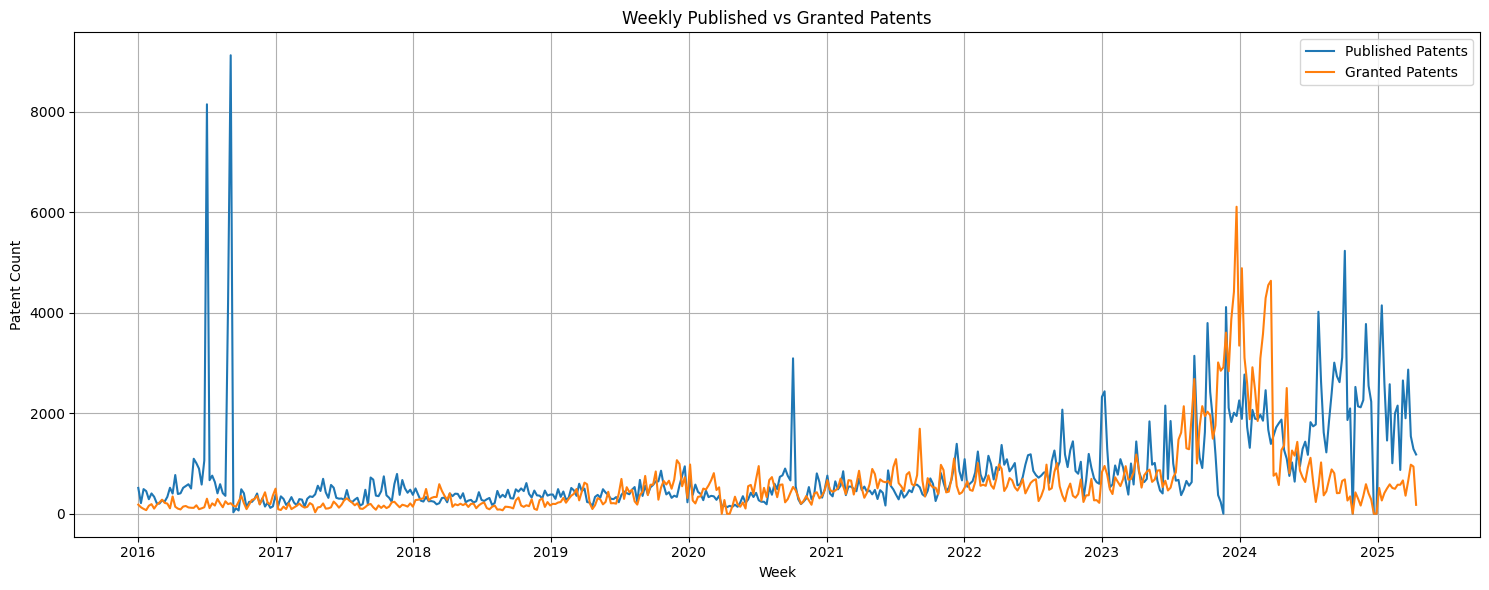

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(weekly_data['Week_Start_Date'], weekly_data['Published_Count'], label='Published Patents')
plt.plot(weekly_data['Week_Start_Date'], weekly_data['Granted_Count'], label='Granted Patents')
plt.xlabel('Week')
plt.ylabel('Patent Count')
plt.title('Weekly Published vs Granted Patents')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Weekly Patent Applications Granted**

In [16]:
#Prepare Time Series
granted_weekly['Week_Start_Date'] = pd.to_datetime(granted_weekly['Week_Start_Date'])
granted_weekly.set_index('Week_Start_Date', inplace=True)
granted_ts = granted_weekly['Granted_Count']

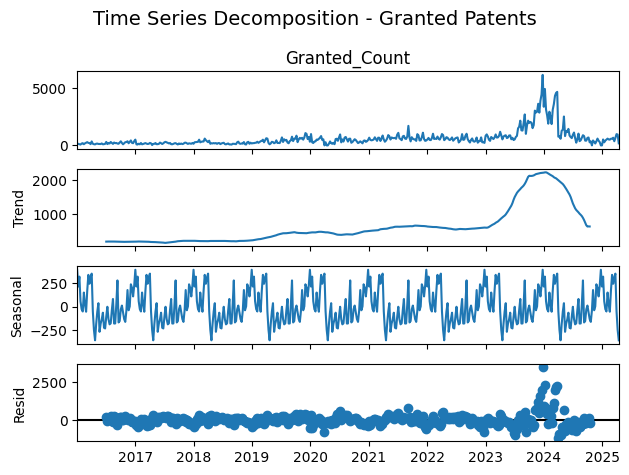

In [18]:
#Decompose Time Series
decomposition = seasonal_decompose(granted_ts, model='additive', period=52)
decomposition.plot()
plt.suptitle("Time Series Decomposition - Granted Patents", fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
#ADF Test for Stationarity
def check_stationarity(ts):
    result = adfuller(ts, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}\nP-Value: {result[1]:.4f}")
    print("=> Stationary" if result[1] < 0.05 else "=> Non-Stationary")

check_stationarity(granted_ts)

ADF Statistic: -3.1865
P-Value: 0.0208
=> Stationary


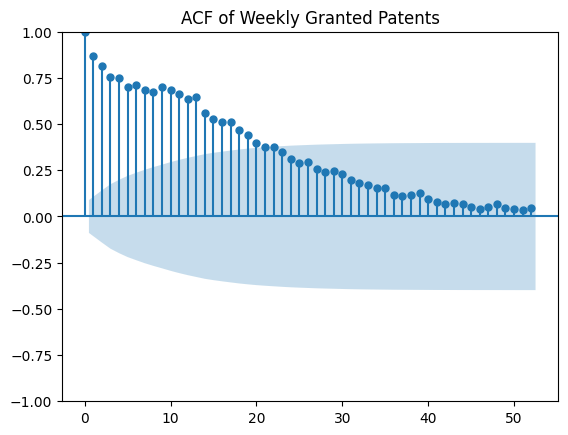

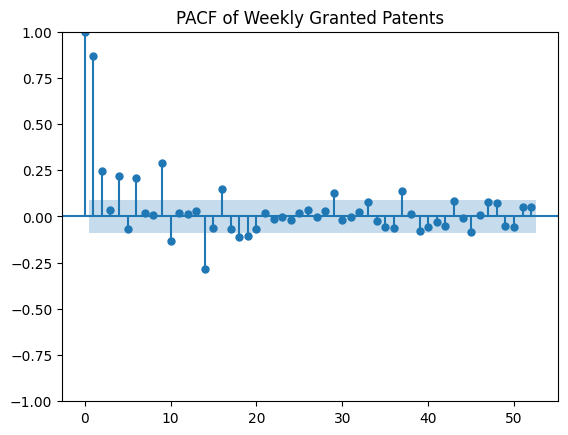

In [39]:
#ACF and PACF Plots
plot_acf(granted_ts, lags=52)
plt.title('ACF of Weekly Granted Patents')
plt.show()

plot_pacf(granted_ts, lags=52)
plt.title('PACF of Weekly Granted Patents')
plt.show()

In [22]:
#SARIMA Model
model = SARIMAX(
    granted_ts,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                      Granted_Count   No. Observations:                  485
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -3197.298
Date:                            Tue, 17 Jun 2025   AIC                           6404.597
Time:                                    14:36:38   BIC                           6424.950
Sample:                                01-03-2016   HQIC                          6412.632
                                     - 04-13-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.006    166.565      0.000       0.988       1.011
ma.L1         -0.3683      0.019   

In [23]:
#Forecast Future 52 Weeks
forecast = results.get_forecast(steps=52)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

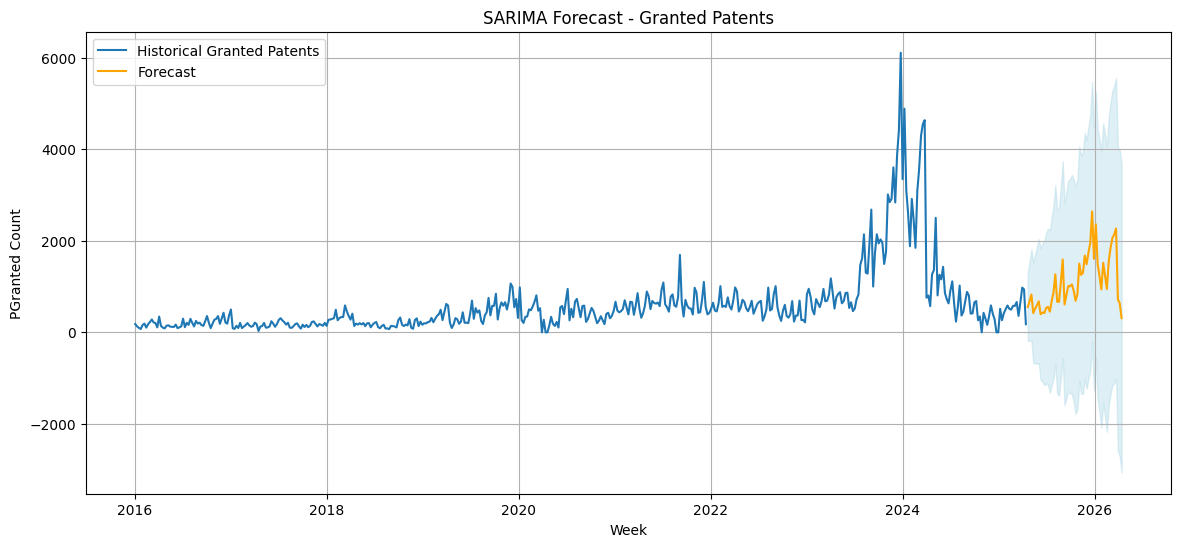

In [24]:
# Plotting the forecast
plt.figure(figsize=(14, 6))
plt.plot(granted_ts, label='Historical Granted Patents')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightblue', alpha=0.4)
plt.title("SARIMA Forecast - Granted Patents")
plt.xlabel("Week")
plt.ylabel("PGranted Count")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
#Forecast Evaluation
actual_values = granted_ts[-52:]
predicted_values = forecast_mean
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
print(f"MAE: {mae:.2f} | MSE: {mse:.2f}")

MAE: 784.39 | MSE: 909029.10


In [27]:
#Outlier Detection via IQR
Q1 = granted_ts.quantile(0.25)
Q3 = granted_ts.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = granted_ts[(granted_ts < lower) | (granted_ts > upper)]
print("\nDetected Outliers:")
print(outliers)


Detected Outliers:
Week_Start_Date
2021-09-05    1692
2023-07-23    1476
2023-07-30    1615
2023-08-06    2140
2023-08-27    1941
2023-09-03    2682
2023-09-17    1736
2023-09-24    2142
2023-10-01    1943
2023-10-08    2031
2023-10-15    1959
2023-10-22    1495
2023-10-29    1757
2023-11-05    3012
2023-11-12    2846
2023-11-19    2916
2023-11-26    3605
2023-12-03    2837
2023-12-10    3871
2023-12-17    4417
2023-12-24    6109
2023-12-31    3346
2024-01-07    4886
2024-01-14    3104
2024-01-21    2596
2024-01-28    1882
2024-02-04    2915
2024-02-11    2462
2024-02-18    1847
2024-02-25    3091
2024-03-03    3578
2024-03-10    4292
2024-03-17    4550
2024-03-24    4636
2024-04-28    1358
2024-05-05    2502
2024-06-02    1431
Name: Granted_Count, dtype: int64


In [28]:
#Replace Outliers with Median
granted_ts_cleaned = granted_ts.copy()
granted_ts_cleaned[(granted_ts_cleaned < lower) | (granted_ts_cleaned > upper)] = granted_ts.median()

In [29]:
#SARIMA on Cleaned Data
model_cleaned = SARIMAX(
    granted_ts_cleaned,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52))
results_cleaned = model_cleaned.fit()
print(results_cleaned.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                      Granted_Count   No. Observations:                  485
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -2906.482
Date:                            Tue, 17 Jun 2025   AIC                           5822.964
Time:                                    14:43:58   BIC                           5843.318
Sample:                                01-03-2016   HQIC                          5830.999
                                     - 04-13-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9600      0.016     59.694      0.000       0.928       0.991
ma.L1         -0.7182      0.031   

In [30]:
forecast_cleaned = results_cleaned.get_forecast(steps=52)
forecast_mean_cleaned = forecast_cleaned.predicted_mean
forecast_ci_cleaned = forecast_cleaned.conf_int()

In [32]:
#Evaluation
actual_cleaned = granted_ts_cleaned[-52:]
predicted_cleaned = forecast_mean_cleaned[:52]
mae_cleaned = mean_absolute_error(actual_cleaned, predicted_cleaned)
mse_cleaned = mean_squared_error(actual_cleaned, predicted_cleaned)
print("(After Outlier Removal)")
print(f"Cleaned MAE: {mae_cleaned:.2f} | Cleaned MSE: {mse_cleaned:.2f}")

(After Outlier Removal)
Cleaned MAE: 140.58 | Cleaned MSE: 35118.02


In [34]:
print("\nForecasted Counts (After Outlier Removal):")
print(predicted_cleaned)


Forecasted Counts (After Outlier Removal):
2025-04-20    780.506320
2025-04-27    599.301184
2025-05-04    580.185291
2025-05-11    586.734735
2025-05-18    757.690183
2025-05-25    787.504009
2025-06-01    585.629755
2025-06-08    595.434176
2025-06-15    586.404200
2025-06-22    585.823573
2025-06-29    741.255398
2025-07-06    759.970413
2025-07-13    576.853621
2025-07-20    329.292205
2025-07-27    509.556979
2025-08-03    734.244901
2025-08-10    649.518821
2025-08-17    666.408644
2025-08-24    593.776538
2025-08-31    665.923813
2025-09-07    716.300073
2025-09-14    378.025206
2025-09-21    409.912326
2025-09-28    526.357948
2025-10-05    522.549271
2025-10-12    347.857464
2025-10-19    354.512190
2025-10-26    314.755241
2025-11-02    500.949625
2025-11-09    327.117099
2025-11-16    306.373549
2025-11-23    427.423000
2025-11-30    592.155703
2025-12-07    382.594042
2025-12-14    342.261395
2025-12-21    236.724431
2025-12-28    379.297013
2026-01-04    539.886931
2026-0

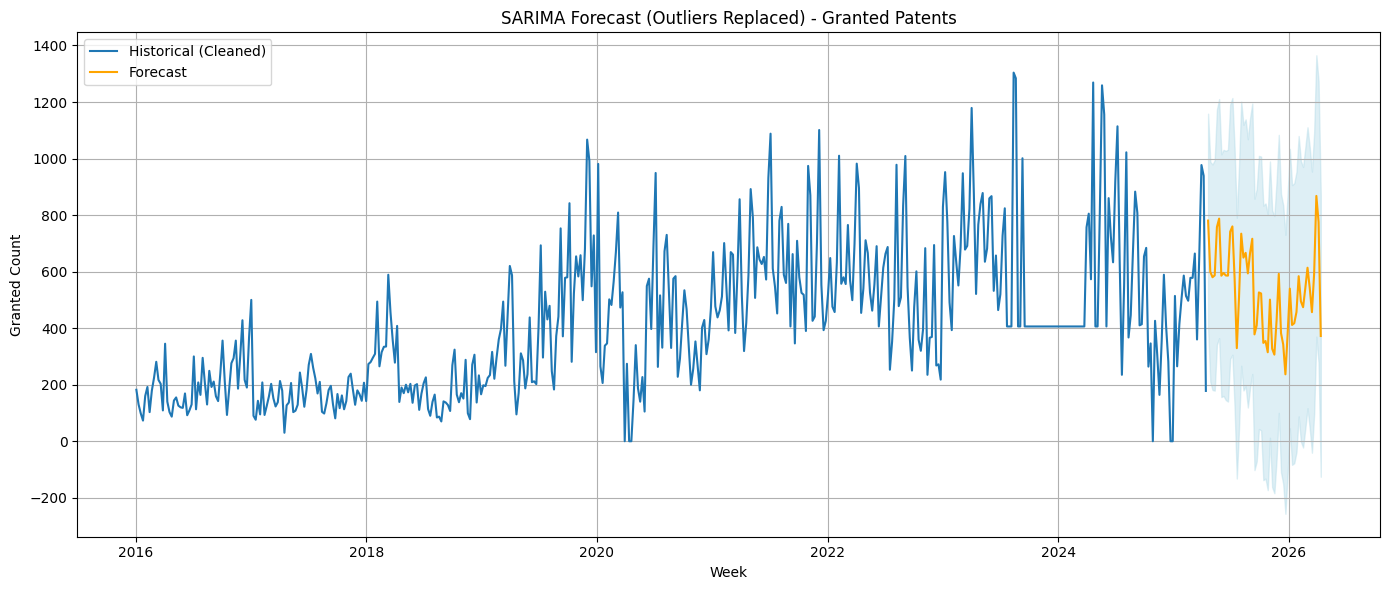

In [33]:
#Plot Cleaned Forecast
plt.figure(figsize=(14, 6))
plt.plot(granted_ts_cleaned, label='Historical (Cleaned)')
plt.plot(forecast_mean_cleaned.index, forecast_mean_cleaned, label='Forecast', color='orange')
plt.fill_between(forecast_ci_cleaned.index,
                 forecast_ci_cleaned.iloc[:, 0],
                 forecast_ci_cleaned.iloc[:, 1], color='lightblue', alpha=0.4)
plt.title("SARIMA Forecast (Outliers Replaced) - Granted Patents")
plt.xlabel("Week")
plt.ylabel("Granted Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## *Final Insights — Granted Patent Forecasting*
By the above code, we can observe that:

- The time series of granted patents shows clear seasonal patterns, repeating roughly every 52 weeks.

- We used the SARIMA(1, 0, 1)(1, 1, 1, 52) model, which captures both trend and seasonality.

- The Augmented Dickey-Fuller (ADF) test showed the data was stationary, hence we set d = 0.

### Model Performance (Before Outlier Removal):
  - MAE: 784.39

  - MSE: 909,029.10

These high error values indicated the presence of extreme fluctuations.

### Outlier Handling:
- Using the IQR method, extreme outliers were detected and replaced with the median of the series.

### Model Performance (After Outlier Removal):
  - Cleaned MAE: 140.58

  - Cleaned MSE: 35,118.02

The model then forecasted the next 52 weeks of granted patent counts.

- The plot showed a stable trend with seasonal oscillations, confirming improved performance post-cleaning.

## **Weekly Patent Applications Published**

In [35]:
#Prepare Time Series
published_weekly['Week_Start_Date'] = pd.to_datetime(published_weekly['Week_Start_Date'])
published_weekly.set_index('Week_Start_Date', inplace=True)
published_ts = published_weekly['Published_Count']

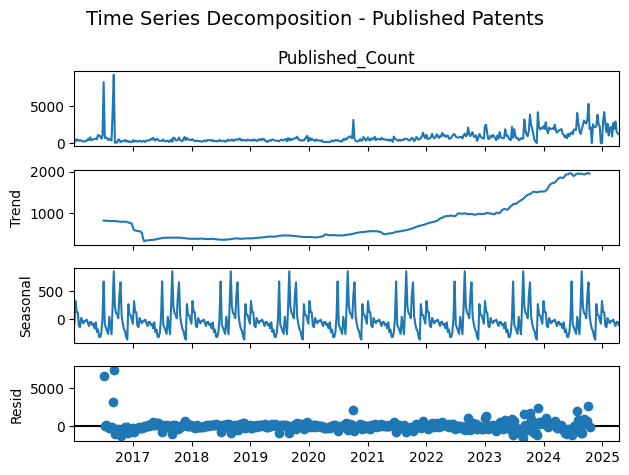

In [37]:
#Decompose Time Series
decomposition = seasonal_decompose(published_ts, model='additive', period=52)
decomposition.plot()
plt.suptitle("Time Series Decomposition - Published Patents", fontsize=14)
plt.tight_layout()
plt.show()

In [38]:
#ADF Test for Stationarity
def check_stationarity(ts):
    result = adfuller(ts, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}\nP-Value: {result[1]:.4f}")
    print("=> Stationary" if result[1] < 0.05 else "=> Non-Stationary")

check_stationarity(published_ts)

ADF Statistic: -2.3129
P-Value: 0.1679
=> Non-Stationary


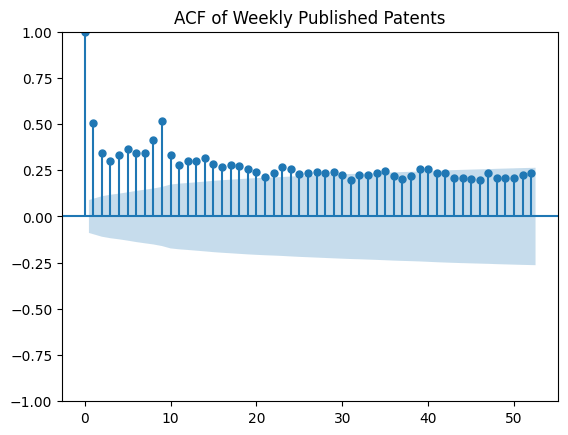

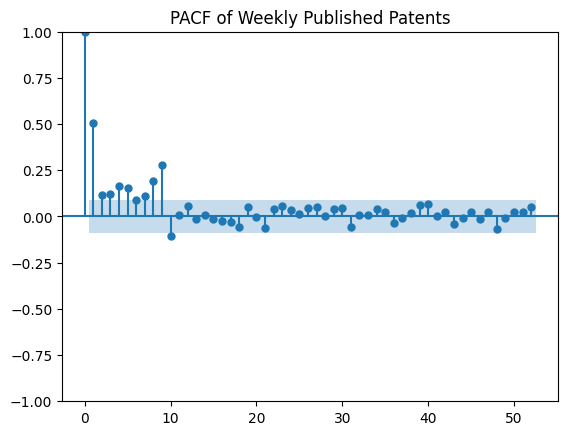

In [40]:
#ACF & PACF Plots
plot_acf(published_ts, lags=52)
plt.title('ACF of Weekly Published Patents')
plt.show()

plot_pacf(published_ts, lags=52)
plt.title('PACF of Weekly Published Patents')
plt.show()

In [47]:
#SARIMA Model
model = SARIMAX(published_ts,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                      Published_Count   No. Observations:                  485
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -2933.716
Date:                              Tue, 17 Jun 2025   AIC                           5881.432
Time:                                      15:20:36   BIC                           5908.958
Sample:                                  01-03-2016   HQIC                          5892.358
                                       - 04-13-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3592      0.444     -0.809      0.419      -1.230       0.511
ar.L2          0.17

In [48]:
# Forecast next 52 weeks
forecast = results.get_forecast(steps=52)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

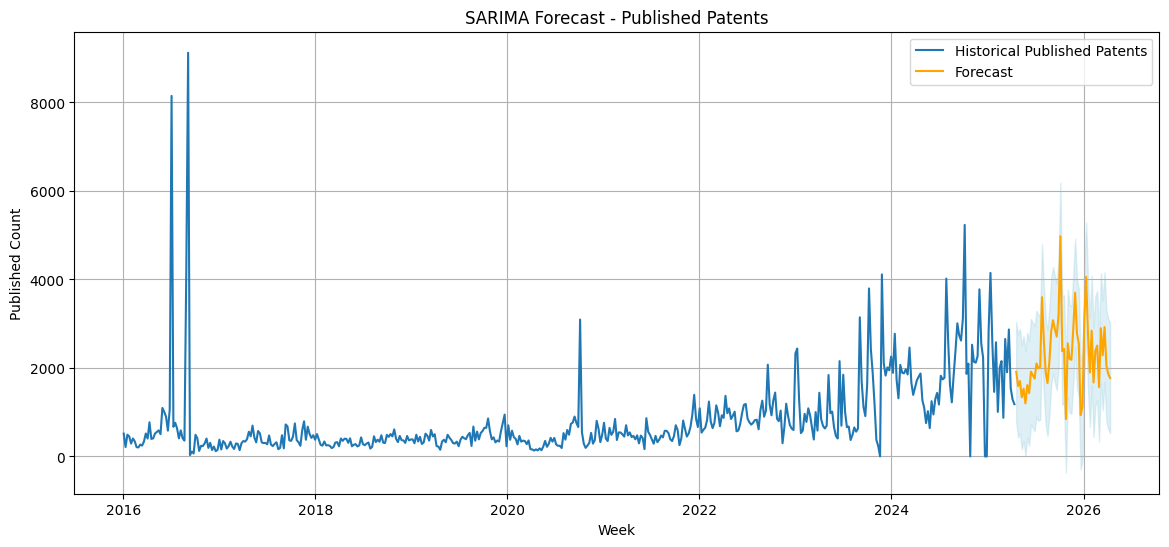

In [49]:
# Plot the forecast
plt.figure(figsize=(14, 6))
plt.plot(published_ts, label='Historical Published Patents')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightblue', alpha=0.4)
plt.title("SARIMA Forecast - Published Patents")
plt.xlabel("Week")
plt.ylabel("Published Count")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#Forecast Evaluation
actual_values = published_ts[-52:]
predicted_values = forecast_mean
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
print(f"MAE: {mae:.2f} | MSE: {mse:.2f}")

MAE: 368.92 | MSE: 195254.68


In [45]:
#Outlier Detection
Q1 = published_ts.quantile(0.25)
Q3 = published_ts.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = published_ts[(published_ts < lower_bound) | (published_ts > upper_bound)]
print("\nDetected Outliers:")
print(outliers)


Detected Outliers:
Week_Start_Date
2016-07-03    8147
2016-08-28    4186
2016-09-04    9123
2020-10-04    3093
2022-09-18    2072
2023-01-01    2326
2023-01-08    2437
2023-05-07    1839
2023-06-18    2153
2023-07-02    1846
2023-09-03    3143
2023-10-08    3795
2023-10-15    2426
2023-10-22    1885
2023-11-26    4113
2023-12-03    2109
2023-12-10    1826
2023-12-17    2011
2023-12-24    1946
2023-12-31    2256
2024-01-07    1889
2024-01-14    2771
2024-02-04    2068
2024-02-11    1892
2024-02-18    1877
2024-02-25    1969
2024-03-03    1852
2024-03-10    2459
2024-04-14    1802
2024-04-21    1874
2024-07-07    1823
2024-07-28    4019
2024-08-04    2621
2024-08-25    1837
2024-09-01    2392
2024-09-08    3007
2024-09-15    2737
2024-09-22    2619
2024-09-29    3111
2024-10-06    5232
2024-10-13    1866
2024-10-20    2096
2024-11-03    2524
2024-11-10    2138
2024-11-17    2119
2024-11-24    2263
2024-12-01    3776
2024-12-08    2547
2024-12-15    2231
2025-01-05    2848
2025-01-12    

In [46]:
# Replace outliers with the median
median_val_p = published_ts.median()
published_ts_cleaned = published_ts.copy()
published_ts_cleaned[(published_ts_cleaned < lower_bound) | (published_ts_cleaned > upper_bound)] = median_val_p

In [51]:
#SARIMA model on cleaned data
model = SARIMAX(published_ts_cleaned,
                order=(2, 1, 1),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                    Published_Count   No. Observations:                  485
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -2672.367
Date:                            Tue, 17 Jun 2025   AIC                           5356.733
Time:                                    15:22:38   BIC                           5380.343
Sample:                                01-03-2016   HQIC                          5366.104
                                     - 04-13-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1702      0.055      3.077      0.002       0.062       0.279
ar.L2         -0.0530      0.048   

In [57]:
forecast_published = results.get_forecast(steps=52)
forecast_mean_published = forecast.predicted_mean
forecast_ci_published = forecast.conf_int()

In [58]:
#Evaluation
actual_values = published_ts_cleaned[-52:]
predicted_values = forecast_mean
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
print(f"MAE: {mae:.2f} | MSE: {mse:.2f}")

MAE: 347.83 | MSE: 161069.00


In [59]:
print("\nForecasted Counts (After Outlier Removal):")
print(predicted_values)


Forecasted Counts (After Outlier Removal):
2025-04-20     845.081086
2025-04-27     882.433219
2025-05-04     822.487333
2025-05-11     881.640389
2025-05-18     917.665511
2025-05-25     740.189238
2025-06-01     777.302924
2025-06-08     843.455049
2025-06-15     942.295303
2025-06-22     983.748914
2025-06-29     829.004033
2025-07-06     810.131673
2025-07-13     945.249541
2025-07-20     928.292360
2025-07-27     696.126723
2025-08-03     728.652905
2025-08-10     914.696557
2025-08-17     955.900442
2025-08-24     875.606410
2025-08-31     805.137249
2025-09-07    1102.797542
2025-09-14     843.312434
2025-09-21     941.063943
2025-09-28    1096.051999
2025-10-05     870.847680
2025-10-12     835.964861
2025-10-19     729.220315
2025-10-26     833.224353
2025-11-02     757.873118
2025-11-09     593.037778
2025-11-16     571.353701
2025-11-23     821.989246
2025-11-30     855.750233
2025-12-07     871.290710
2025-12-14     772.658833
2025-12-21     630.101752
2025-12-28     713.8

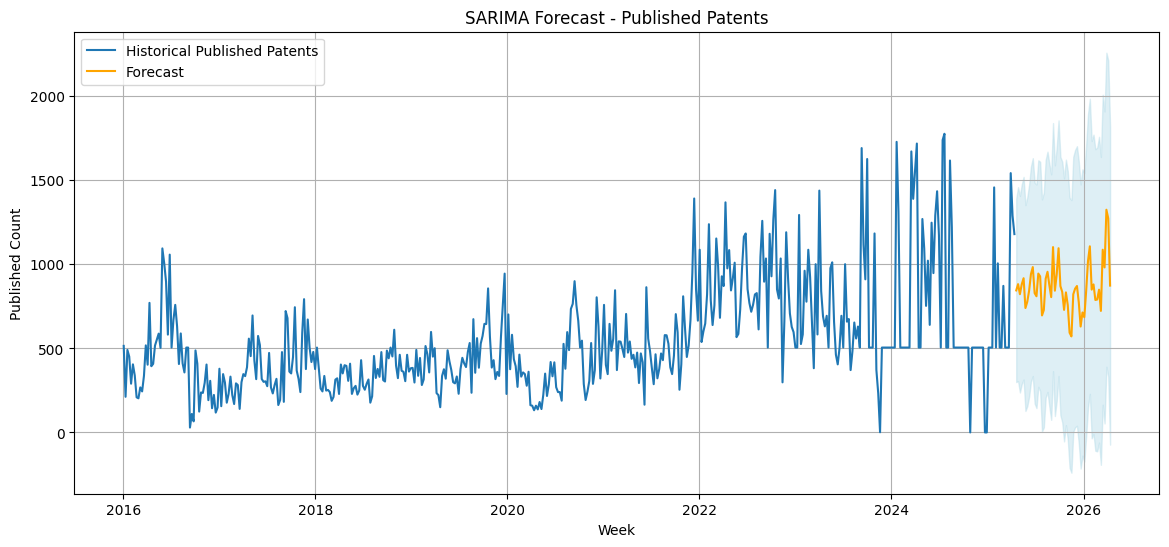

In [60]:
# Plot the forecast
plt.figure(figsize=(14, 6))
plt.plot(published_ts_cleaned, label='Historical Published Patents')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightblue', alpha=0.4)
plt.title("SARIMA Forecast - Published Patents")
plt.xlabel("Week")
plt.ylabel("Published Count")
plt.legend()
plt.grid(True)
plt.show()

## *Final Insights – Published Patents Forecasting*
By the above code, we can observe that:

- The published patent data also exhibits seasonal behavior, repeating every 52 weeks.

=- We applied the SARIMA(1, 0, 1)(1, 1, 1, 52) model to capture these cyclical patterns.

- The ADF test confirmed the series was non-stationary, so d = 1 was used.

### Model Performance (Before Outlier Removal):
- MAE: 368.92

- MSE: 195,254.68

### Outlier Handling:
- Outliers were identified using the IQR method and replaced with the median.

### Model Performance (After Outlier Removal):
- Cleaned MAE: 347.83

- Cleaned MSE: 161,069.00

- The 52-week forecast provided by the model displayed seasonal ups and downs consistent with past behavior.

- Although the improvement post-cleaning wasn’t as drastic as with the granted data, the model still became more stable and reliable.

## **Comparative Forecasting:**

**Published vs Granted Patents**

To understand the relationship and behavior between patent applications (published) and granted patents, we perform a comparative time series forecast. We trained SARIMA models on both datasets after outlier treatment and plotted their:

- Historical weekly trends (dashed lines)

- 52-week forecast projections (solid lines)

This allows us to visually analyze the patterns, seasonality, and volatility across both patent types.

In [63]:
print("Granted ends on:", granted_ts_cleaned.index[-1])
print("Published ends on:", published_ts_cleaned.index[-1])

print("Granted forecast starts:", forecast_mean_cleaned.index[0])
print("Published forecast starts:", forecast_mean_published.index[0])


Granted ends on: 2025-04-13 00:00:00
Published ends on: 2025-04-13 00:00:00
Granted forecast starts: 2025-04-20 00:00:00
Published forecast starts: 2025-04-20 00:00:00


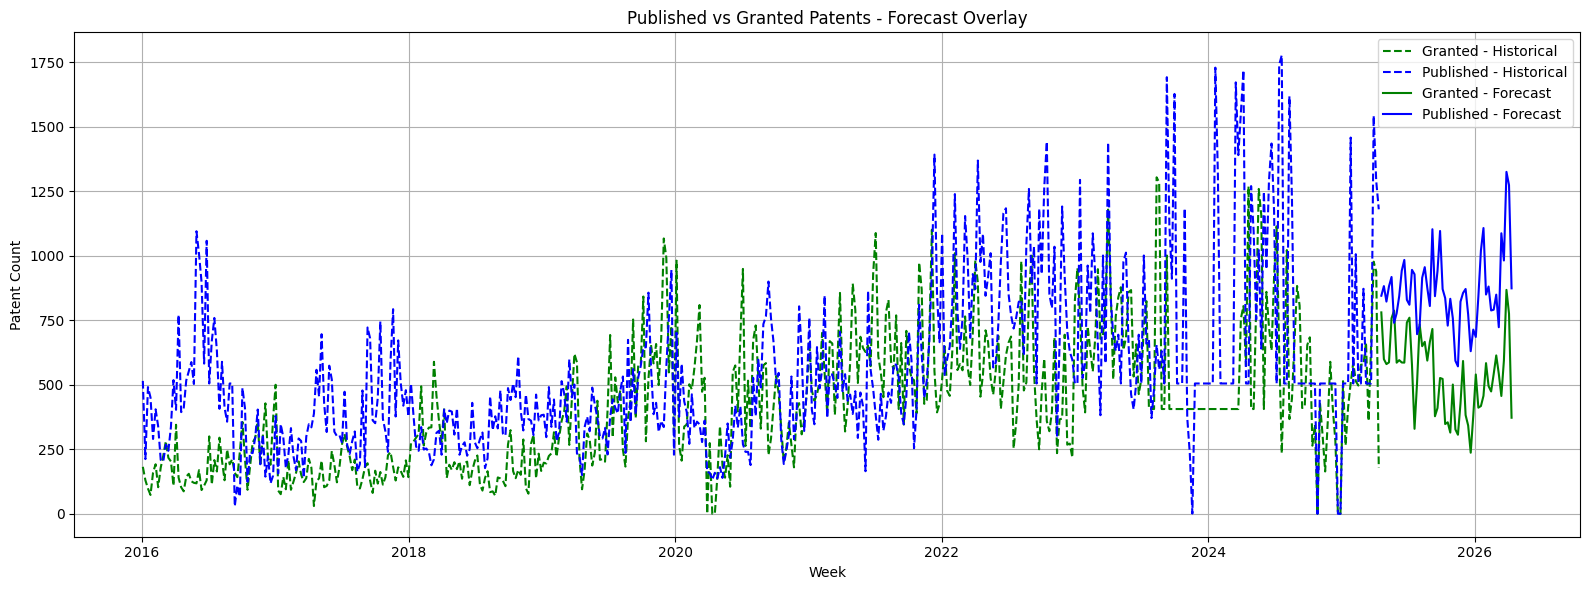

In [64]:
plt.figure(figsize=(16, 6))
plt.plot(granted_ts_cleaned, label='Granted - Historical', linestyle='--', color='green')
plt.plot(published_ts_cleaned, label='Published - Historical', linestyle='--', color='blue')

plt.plot(forecast_mean_cleaned, label='Granted - Forecast', color='green')
plt.plot(forecast_mean_published, label='Published - Forecast', color='blue')

plt.title("Published vs Granted Patents - Forecast Overlay")
plt.xlabel("Week")
plt.ylabel("Patent Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Insights:

By the above comparison plot, we observe:

- Both granted and published patents show seasonal behavior, repeating annually.

- Forecasts begin from 2025-04-20 for both series and extend 52 weeks ahead.

- Published patents show slightly more volatility than granted ones, even after outlier treatment.

- The granted forecast remains more stable, while published has occasional spikes, possibly reflecting irregular submission patterns.

- Overall, both trends move in parallel, indicating that the number of granted patents is proportionally tied to the number of published applications over time.

## **Trend Gap Analysis:**

**Published vs Granted Patents**

We calculate the weekly difference between the number of patents published and granted:

In [66]:
weekly_data['Trend_Gap'] = weekly_data['Published_Count'] - weekly_data['Granted_Count']

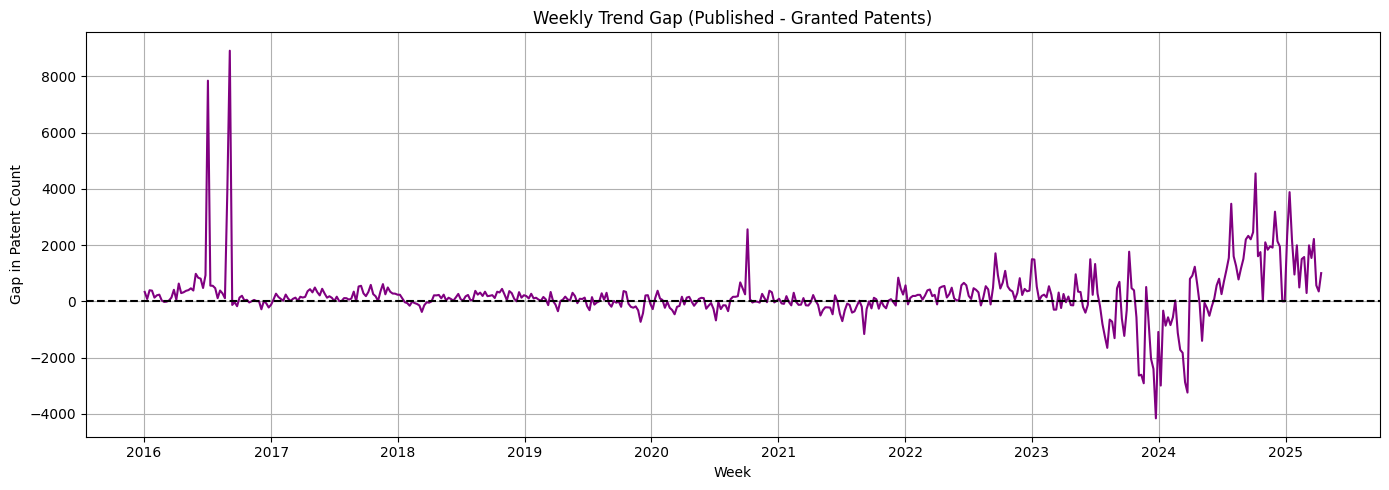

In [67]:
plt.figure(figsize=(14, 5))
plt.plot(weekly_data['Week_Start_Date'], weekly_data['Trend_Gap'], color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Weekly Trend Gap (Published - Granted Patents)")
plt.xlabel("Week")
plt.ylabel("Gap in Patent Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Insights:
- Published patent counts are consistently higher than granted patents, indicating a significant backlog or processing time between application and grant.

- A positive gap means more patents were published than granted that week.

- A negative gap (if any) would mean more grants than publications, which is rare.

- The gap typically fluctuates but stays above zero.

- Sudden spikes may reflect policy changes, bulk processing, or administrative delays.

## **Published-to-Granted Ratio Analysis**
We compute the ratio of published to granted patents for each week:

In [68]:
weekly_data['Pub_Grant_Ratio'] = weekly_data['Published_Count'] / weekly_data['Granted_Count'].replace(0, np.nan)

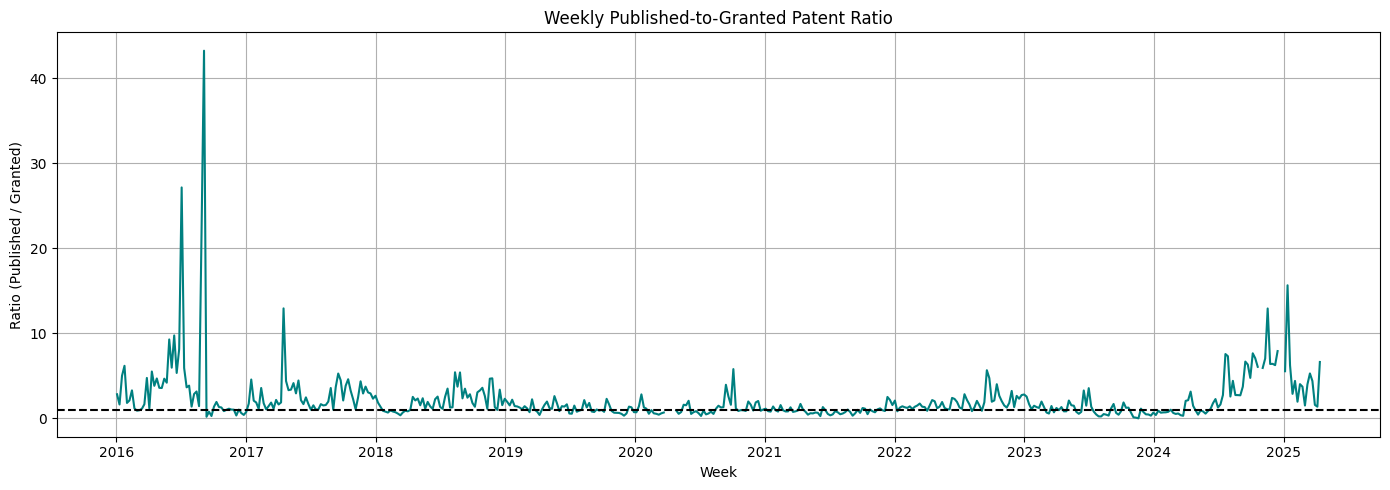

In [69]:
plt.figure(figsize=(14, 5))
plt.plot(weekly_data['Week_Start_Date'], weekly_data['Pub_Grant_Ratio'], color='teal')
plt.axhline(1, color='black', linestyle='--')
plt.title("Weekly Published-to-Granted Patent Ratio")
plt.xlabel("Week")
plt.ylabel("Ratio (Published / Granted)")
plt.grid(True)
plt.tight_layout()
plt.show()

Insights:
- A ratio > 1 means more patents were published than granted — which is the usual case.

- A ratio < 1 would indicate rare cases where more patents were granted than published.

- The ratio helps measure the efficiency of the granting process — a higher ratio may signal longer wait times or bottlenecks in the examination process.

- Periods with spikes in ratio may indicate delays in granting or sudden increases in publication volume.

In [71]:
# Print summary statistics
print("Min:", weekly_data['Pub_Grant_Ratio'].min())
print("Max:", weekly_data['Pub_Grant_Ratio'].max())
print("Mean:", weekly_data['Pub_Grant_Ratio'].mean())

Min: 0.0003429355281207133
Max: 43.23696682464455
Mean: 2.154178925069933


## **Grant-to-Publish Ratio**

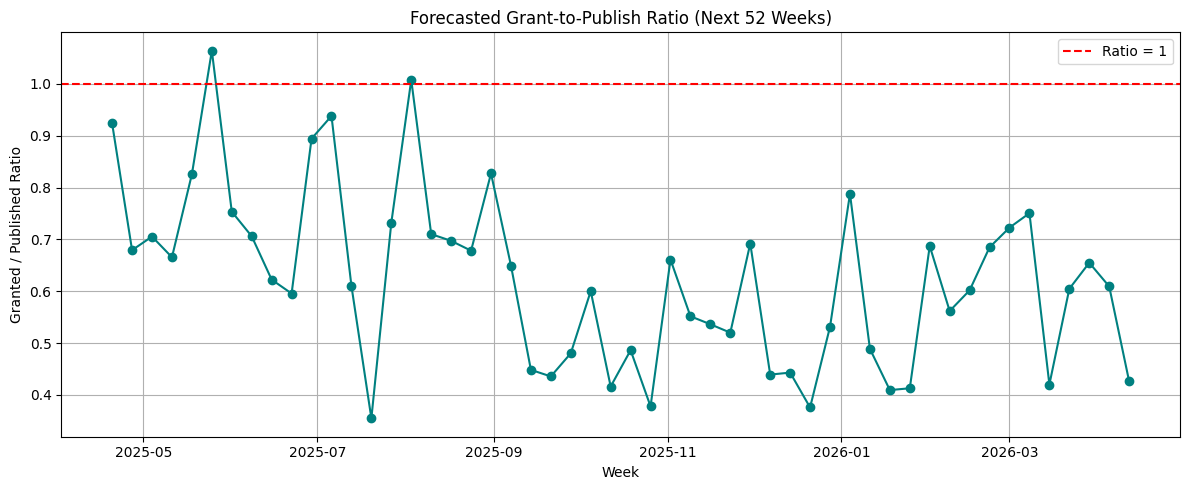

Grant-to-Publish Ratio Summary:
Min: 0.35
Max: 1.06
Mean: 0.62


In [70]:
# Calculate the grant-to-publish ratio
ratio = forecast_mean_cleaned / forecast_mean_published
ratio = ratio.replace([np.inf, -np.inf], np.nan).fillna(0)  # handle division by zero

# Plot the ratio
plt.figure(figsize=(12, 5))
plt.plot(ratio.index, ratio, marker='o', linestyle='-', color='teal')
plt.axhline(y=1, color='red', linestyle='--', label='Ratio = 1')
plt.title("Forecasted Grant-to-Publish Ratio (Next 52 Weeks)")
plt.xlabel("Week")
plt.ylabel("Granted / Published Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Grant-to-Publish Ratio Summary:")
print(f"Min: {ratio.min():.2f}")
print(f"Max: {ratio.max():.2f}")
print(f"Mean: {ratio.mean():.2f}")


Insights:
- The Grant-to-Publish ratio fluctuates weekly, indicating that not all published patents are granted at a consistent rate.
- The ratio ranges from 0.35 to 1.06, with a mean of 0.62.

- This means that, on average, only about 62% of published patents are expected to be granted.

- Occasionally, the ratio exceeds 1, possibly due to timing misalignments or pending backlog grants.

- This comparative metric offers a realistic glimpse into grant conversion efficiency over time.

#**Overall Conclusion**

This project aimed to model, forecast, and compare the weekly trends in Published and Granted patents using SARIMA, along with additional statistical insights. Here's a complete summary of our findings:

- *Published vs. Granted Volume:* Published patents consistently outnumber granted patents, reinforcing the idea that not all filed applications lead to grants.

- *Stationarity:* The Granted patents time series was found to be stationary, while the Published series was non-stationary, justifying the use of d=1 in SARIMA modeling for published data.

- *Forecast Accuracy:*

  - Outlier removal significantly improved model accuracy.

  - For example, in granted data, MAE reduced from 784.39 to 140.58 after outlier treatment.

  - A similar trend was observed in the published dataset in which MAE reduced from 368.92 to 347.83.

- *Forecast Trend Comparison:* Both forecasts showed seasonal behavior. However, published forecasts remained higher than granted, continuing the historical pattern.

- *Trend Gap Analysis:* The gap between published and granted patents was visualized and tracked over time, revealing consistent disparities, except for rare convergence weeks.

- *Published-to-Granted Ratio:* Weekly ratio analysis showed that:

  - The Published-to-Granted ratio has a mean of 2.15, i.e., on average, 2.15 patents are published for every 1 granted.

- *Granted-to-Published Ratio:*

  - The mean was ~0.62, implying ~62% of published patents eventually get granted.

  - The ratio fluctuated between 0.35 (low) and 1.06 (rare peak).

Together, these analyses provide a robust understanding of the patent pipeline behavior in India, from publication to grant. This can inform IP strategy, policy planning, and resource allocation.